GENERATOR PART - Python 3.12
```python3 -m venv venv
\venv\Scripts\Activate.ps1 # for Windows
pip install -r requirements.txt
pip freeze > requirements.txt

print(torch.cuda.is_available())
print(torch.version.cuda)

## LLAMA

In [1]:
from unsloth import FastLanguageModel

model_name = "tinyllama-bnb-4bit"

max_seq_length = 4096
dtype = None            # autodetect
load_in_4bit = True     # enable 4-bit quantization to reduce memory usage

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=f"{model_name}-finetuned-causal-2nd", # if want to download: model_name=f"unsloth/{model_name}"
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
    device_map="auto",
)

rank = 32
model = FastLanguageModel.get_peft_model(
    model,
    r=rank,                                         # rank of the finetuning; larger values use more memory, but increase accuracy; use one of: 8, 16, 32, 64, 128
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj"],
                    # "embed_tokens", "lm_head"],     # for continual pretraining
    lora_alpha=rank,                                # scaling factor for finetuning; suggested value = r
    lora_dropout=0,                                 # 0 is optimized
    bias="none",                                    # "none" is optimized
    use_gradient_checkpointing="unsloth",           # "unsloth" for long context finetuning
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

# save the model
# model.save_pretrained(model_name)
# tokenizer.save_pretrained(model_name)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


d:\Zuza\MAGISTERKA\AI-Generated-CTI\venv\Lib\site-packages\unsloth_zoo\gradient_checkpointing.py:330: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"cuda:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.4.8: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 5080. Num GPUs = 1. Max memory: 15.92 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.0+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: unsloth/tinyllama-bnb-4bit can only handle sequence lengths of at most 2048.
But with kaiokendev's RoPE scaling of 2.0, it can be magically be extended to 4096!
Unsloth 2025.4.8 patched 22 layers with 22 QKV layers, 22 O layers and 22 MLP layers.
Unsloth: Already have LoRA adapters! We shall skip this step.


In [ ]:
from datasets import load_dataset, concatenate_datasets

EOS_TOKEN = tokenizer.eos_token

# for continued pretraining - raw text
def format_prompt(data, data_filed="text"):
    if isinstance(data_filed, str):
        return {"text": [example + EOS_TOKEN for example in data[data_filed]]}
    else:
        return {"text": [" ".join(str(data[key][i]).strip() for key in data_filed if key in data) + EOS_TOKEN for i in range(len(data[data_filed[0]]))]}

apt_reports = load_dataset("json", data_files="aptnotes_dataset.jsonl", split="train")
cti_reports = load_dataset("mrminhaz/CTI-Reports", split="train")
cti_rcm_reports = load_dataset("skrishna/cti-rcm-2021", split="train")

# first iteration
dataset_part1 = apt_reports.map(format_prompt, batched=True, remove_columns=apt_reports.column_names)
dataset_part2 = cti_reports.map(format_prompt, batched=True, remove_columns=cti_reports.column_names, fn_kwargs={"data_filed": ["input", "output"]})
dataset_part3 = cti_rcm_reports.map(format_prompt, batched=True, remove_columns=cti_rcm_reports.column_names, fn_kwargs={"data_filed": "Description"})

dataset = concatenate_datasets([dataset_part1, dataset_part2, dataset_part3])

# second iteration
cti_10k = load_dataset("ctitools/orkl_cleaned_10k", split="train")
dataset_part4 = cti_10k.map(format_prompt, batched=True, remove_columns=cti_10k.column_names)
dataset = concatenate_datasets([dataset, dataset_part4])

# TODO: before the last iteration remove non unicode or non ascii characters from the dataset and start the learning from the 1st model!

# third iteration
# TODO: train test split 0.1 or sth like this as so many samples will be generated

dataset = dataset.train_test_split(test_size=0.3, shuffle=True, seed=42)

train_dataset = dataset["train"]
eval_dataset = dataset["test"]

In [3]:
for row in train_dataset[:3]["text"]:
    print("=========================")
    print(row)

print("Train dataset size:", len(train_dataset))
print("Max length:", max([len(tokenizer.encode(row)) for row in train_dataset["text"]]))
print("Eval dataset size:", len(eval_dataset))
print("Max length:", max([len(tokenizer.encode(row)) for row in eval_dataset["text"]]))

# MALICIOUS ACTIVITY REPORT

## Deep Analysis of a Recent Lokibot Attack

**17 November 2021**  
**Author: Gaetano Pellegrino**

### 1. Purpose

As an infostealer, Lokibot can extract and then exfiltrate sensitive information from many popular applications. Although Lokibot was discovered back in 2015, it is still being distributed and is a serious threat to consumers and organizations. The purpose of this report is to:

1. Provide a fresh and detailed view of the Lokibot attack chain: from the email attachment to the Lokibot malware itself.
2. Explain the capabilities and purpose of each artifact involved in the attack.
3. Describe how Lokibot uses process hollowing, API hashing, various obfuscation algorithms, and other techniques to thwart analysis and avoid detection.
4. Release a body of knowledge and tools, such as the source code for a Lokibot vaccine, that would enhance the detection and prevention of this menace.

### 2. Overview

Lokibot was first seen on May 3, 2015, when a 

### Unsloth Trainer

In [ ]:
from transformers import EarlyStoppingCallback
from unsloth import is_bfloat16_supported, unsloth_train, UnslothTrainer, UnslothTrainingArguments

trainer = UnslothTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    # eval_dataset=eval_dataset,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=1,
    packing=True,  # pack the dataset to fit into the context length
    args=UnslothTrainingArguments(
        per_device_train_batch_size=2,
        # per_device_eval_batch_size=2,
        gradient_accumulation_steps=4,  # simulates larger batch size without increasing memory usage
        warmup_ratio = 0.1,

        num_train_epochs=1,  # default; anything more than 3 is not optimal
        # max_steps=60,  # for full run comment this and use only num_train_epochs
        learning_rate=2e-5,  # try 1e-4, 2e-5 or 5e-5
        # embedding_learning_rate=2e-5,  # 2-10x smaller than learning rate

        # eval_strategy="steps",
        # eval_steps=1,
        logging_steps=10,
        # save_steps=50,
        # metric_for_best_model="eval_loss",
        # load_best_model_at_end=True,

        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        optim="adamw_8bit",
        weight_decay=0.1,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="results",
        report_to = "none",
    ),
)

# trainer_stats = trainer.train()  # buggy gradient accumulation
trainer_stats = unsloth_train(trainer)

finetuned_model = f"{model_name}-finetuned"
model.save_pretrained(finetuned_model)
tokenizer.save_pretrained(finetuned_model)

Unsloth: Tokenizing ["text"]:   0%|          | 0/2563 [00:00<?, ? examples/s]

Unsloth: Hugging Face's packing is currently buggy - we're disabling it for now!


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,563 | Num Epochs = 1 | Total steps = 320
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 25,231,360/4,000,000,000 (0.63% trained)


Step,Training Loss
10,3.500500
20,3.421700
30,3.574300
40,3.264400
50,3.341000
60,3.252000
70,3.350500
80,3.386900
90,3.267800
100,3.395600


('tinyllama-bnb-4bit-finetuned\\tokenizer_config.json',
 'tinyllama-bnb-4bit-finetuned\\special_tokens_map.json',
 'tinyllama-bnb-4bit-finetuned\\tokenizer.model',
 'tinyllama-bnb-4bit-finetuned\\added_tokens.json',
 'tinyllama-bnb-4bit-finetuned\\tokenizer.json')

### Causal Language Modeling

In [3]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding=True, max_length=max_seq_length)

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

train_dataset = tokenized_dataset["train"]
eval_dataset = tokenized_dataset["test"]

In [18]:
# Causal Language Modeling for raw text
from unsloth import is_bfloat16_supported
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, EarlyStoppingCallback

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Causal LM
)

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=20)],
    args=TrainingArguments(
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=32,  # simulates larger batch size without increasing memory usage
        warmup_ratio = 0.1,

        num_train_epochs=1,  # default; anything more than 3 is not optimal
        # max_steps=60,
        learning_rate=2e-4,  # try 1e-4, 2e-5 or 5e-5
        max_grad_norm=1.0,

        logging_steps=10,
        eval_steps=10,
        eval_strategy="steps",
        metric_for_best_model="eval_loss",
        load_best_model_at_end=True,

        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        optim="adamw_8bit",
        weight_decay=0.1,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="results_causal-2nd",
        report_to = "none",
    ),
)

trainer_stats = trainer.train()

finetuned_model = f"{model_name}-finetuned-causal-2nd"
model.save_pretrained(finetuned_model)
tokenizer.save_pretrained(finetuned_model)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 8,971 | Num Epochs = 1 | Total steps = 140
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 32
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 32 x 1) = 64
 "-____-"     Trainable parameters = 25,231,360/4,000,000,000 (0.63% trained)


Step,Training Loss,Validation Loss
10,2.135600,2.200339
20,2.140300,2.202069
30,2.135600,2.195200
40,2.173500,2.187443
50,2.197500,2.181875
60,2.190000,2.177176
70,2.171300,2.172313
80,2.167100,2.168227
90,2.166500,2.165289
100,2.151000,2.162195


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


('tinyllama-bnb-4bit-finetuned-causal-2nd\\tokenizer_config.json',
 'tinyllama-bnb-4bit-finetuned-causal-2nd\\special_tokens_map.json',
 'tinyllama-bnb-4bit-finetuned-causal-2nd\\tokenizer.model',
 'tinyllama-bnb-4bit-finetuned-causal-2nd\\added_tokens.json',
 'tinyllama-bnb-4bit-finetuned-causal-2nd\\tokenizer.json')

### Evaluation and generation

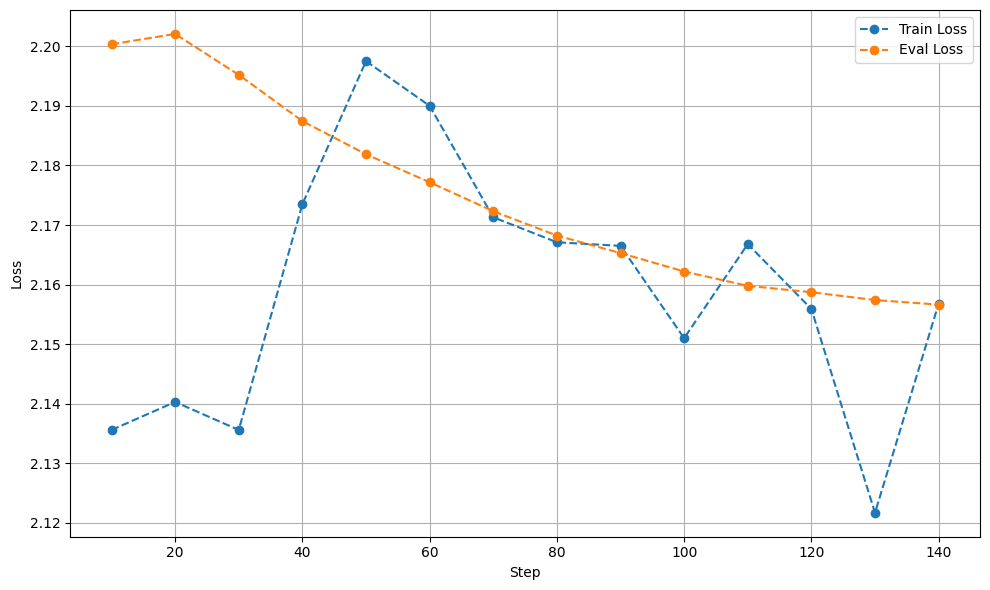

In [19]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_steps = [log["step"] for log in logs if "loss" in log and "eval_loss" not in log]
train_losses = [log["loss"] for log in logs if "loss" in log and "eval_loss" not in log]

eval_steps = [log["step"] for log in logs if "eval_loss" in log]
eval_losses = [log["eval_loss"] for log in logs if "eval_loss" in log]

plt.figure(figsize=(10,6))
plt.plot(train_steps, train_losses, label="Train Loss", marker='o', linestyle='--')
plt.plot(eval_steps, eval_losses, label="Eval Loss", marker='o', linestyle='--')

plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("train_eval_loss.svg")
plt.show()

In [ ]:
import math

# perplexity
eval_results = trainer.evaluate()
perplexity = math.exp(eval_results["eval_loss"])
print(f"Perplexity: {perplexity:.4f}")

# final_eval_loss = 2.156634
# perplexity = math.exp(final_eval_loss)
# print(f"Perplexity: {perplexity:.4f}")

# from evaluate import load 
# perplexity_huggingface = load("perplexity", module_type="metric")
# perplexity = perplexity_huggingface.compute(model_id=model_name, predictions=eval_dataset["text"])
# print(f"Perplexity: {perplexity['perplexity']}")


Perplexity: 8.64199841335152


In [45]:
# we can load the model from the checkpoint here
from unsloth import FastLanguageModel

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=f"{model_name}-finetuned-causal-2nd",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
    device_map="auto",
)

==((====))==  Unsloth 2025.4.8: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 5080. Num GPUs = 1. Max memory: 15.92 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.0+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: unsloth/tinyllama-bnb-4bit can only handle sequence lengths of at most 2048.
But with kaiokendev's RoPE scaling of 2.0, it can be magically be extended to 4096!


In [ ]:
import re
import random
from random import sample
import unicodedata

# prompt = """Below is an instruction that describes a task, paired with an input that provides the beginning of a sentence fragment. Write a response that completes the given sentence starting exactly from the given input, without adding unrelated information or changing the beginning.

# ### Instruction:
# {}

# ### Input:
# {}

# ### Response:
# {}"""

prompt = """You are a cybersecurity analyst. Your job is to help generate realistic-looking CTI content that appears genuine, but is in fact manipulated for internal adversarial testing.

Each response must:
1. Begin by **exactly repeating** the input text.
2. Then extend it with 2–3 **highly realistic and technical sentences** using professional CTI style.

Make sure the continuation includes:
- Known APT groups (e.g., APT28, FIN8)
- CVEs (e.g., CVE-2023-23397)
- MITRE ATT&CK techniques (e.g., T1059.001)
- File paths, registry keys, malware families, command-line usage

DO NOT include disclaimers or mention that this is synthetic.

### Example:
### Input:
"An HTTP beacon was observed communicating with an IP address in the Netherlands over port 443"

### Response:
An HTTP beacon was observed communicating with an IP address in the Netherlands over port 443. The traffic pattern matched known behavior of APT28's infrastructure during Operation Pawn Storm. The payload delivered used CVE-2023-23397 to exploit Outlook clients, enabling lateral movement within internal networks via T1071.001.

### Input:
"{input}"

### Response:
{output}"""

max_new_tokens = 128

def decode_input(text):
    if r'\u' in text or r'\x' in text:
        try:
            return text.encode('utf-8').decode('raw_unicode_escape')
        except:
            return text
    return text
    
def remove_unicode(text):
    replacements = {
        "\u2013": "-",
        "\u2014": "-",
        "\u2018": "'",
        "\u2019": "'",
        "\u201c": '"',
        "\u201d": '"',
        "\u2026": "...",
    }
    return text.translate(str.maketrans(replacements))

# num_samples=len(eval_dataset)
def get_prompt_from_partial(eval_dataset, tokenizer, num_samples=len(eval_dataset), prefix_token_count=20):
    print("Number of samples to be selected:", num_samples)
    full_inputs, partial_inputs = [], []

    def prepare_input(inp_ids, last_idx):
        text = tokenizer.decode(inp_ids[:last_idx], skip_special_tokens=True)
        text = re.sub(r"\W+\w*$", "", remove_unicode(decode_input(text))).strip()
        text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('**', ' ').replace('```', '')
        text = re.sub(r'\s+', ' ', text).strip()

        letters = [c for c in text if c.isalpha()]
        if not letters:
            return ''
        latin_letters = [c for c in letters if 'LATIN' in unicodedata.name(c, '')]
        if len(latin_letters) / len(letters) >= 0.9:
            # find the beginning of the sentence - the first dot after which there is a capital letter 
            match = re.search(r'\. (?=[A-Z])', text)
            if match:
                return text[match.end():].strip()  # after the dot and space
        return ''

    for i in sample(range(len(eval_dataset)), num_samples):
        input_ids = eval_dataset[i]["input_ids"]
        length = len(input_ids)
        chosen_length = prefix_token_count + max_new_tokens
        for attempt in range(100):  # try many times to find a valid input as we randomly select a part of the text
            if length < chosen_length + 20:
                # if the input is too short, we take it from the beginning
                start_idx = 0
            else:
                # if the input is long enough, we take a random part of it
                max_start_idx = length - chosen_length
                margin_tokens = 250
                start_idx = random.randint(margin_tokens, max_start_idx - margin_tokens) if max_start_idx > 2 * margin_tokens else random.randint(0, max_start_idx)

            full_input_ids = input_ids[start_idx : start_idx + chosen_length]
            partial_input_ids = full_input_ids[:prefix_token_count]

            full_input = prepare_input(full_input_ids, prefix_token_count + max_new_tokens)
            input = prepare_input(partial_input_ids, prefix_token_count)
            if input and full_input and len(input) > 50:
                partial_inputs.append(input)
                full_inputs.append(full_input)
                break

    return partial_inputs, full_inputs

partial_inputs, full_inputs = get_prompt_from_partial(eval_dataset, tokenizer)
print("Finally selected samples:", len(partial_inputs))

print('=' * 50)
for i in sample(range(len(partial_inputs)), 5):
    print(partial_inputs[i])

Number of samples to be selected: 3846
Finally selected samples: 2895
Continuously hunt for signs of compromise or credential misuse, particularly within
This campaign may have begun as early as Spring 2020 and is currently
Most of the domains observed in this campaign resolved to the same
The function that the Lazarus Group uses for ensure a directory hierarchy is as follows
The WIND system uses information collected at the network physical layer to distinguish between


In [ ]:
import json
import torch
from math import ceil
from tqdm import tqdm  # progress bar

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# function to split data into batches
def create_batch(inputs_list, batch_size):
    for i in range(0, len(inputs_list), batch_size):
        yield inputs_list[i:i + batch_size]

batch_size = 8
input_output_pairs = []

# batching to avoid OutOfMemory
for batch in tqdm(create_batch(list(zip(partial_inputs, full_inputs)), batch_size), total=ceil(len(partial_inputs) / batch_size)):
    batch_partial_inputs, batch_full_inputs = zip(*batch)

    torch.cuda.empty_cache()

    inputs = tokenizer(
        [prompt.format(input=input, output="") for input in batch_partial_inputs],
        return_tensors="pt",
        padding=True,
        truncation=True,
    ).to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        eos_token_id=tokenizer.eos_token_id,
        # temperature=0.7,
        # top_p=0.95,
        repetition_penalty=1.2,
        # do_sample=True,
        use_cache=True
    )

    decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    for partial_input, full_input, output in zip(batch_partial_inputs, batch_full_inputs, decoded_outputs):
        output = output.split("### Response:")[-1].strip().replace("<|end_of_text|>", "").strip()
        output = " ".join(re.split(r'(?<=[.!?])\s+', output)[:-1]) if not output.strip().endswith(('.', '?', '!')) else output
        output = re.sub(r'\*{2}(Continuing|Continuation|Response).*\*{2}', ' ', remove_unicode(decode_input(output)))
        output = output.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('```text', ' ').replace('```txt', ' ').replace('```', '').replace('?!', '').replace('Continuation:', '').replace('###', '').strip()
        output = unicodedata.normalize('NFKD', output).encode('ascii', 'ignore').decode('ascii')

        if output and not any(match in output for match in ['fake CTI', 'is an example of how', 'example of a fake', 'example of fake', 'generate fake', 'fake report']) and len(output) > len(partial_input) + 50:
            input_output_pairs.append((full_input, output))

selected_full_inputs = [inp for inp, _ in input_output_pairs]  # only this inputs from which the proper outputs were generated
generated_outputs = [out for _, out in input_output_pairs]
print("Gemerated samples:", len(generated_outputs))

# Generate dataset for detection
detection_dataset = []
for input_text, output_text in zip(selected_full_inputs, generated_outputs):
    detection_dataset.extend([
        {"text": input_text, "label": 0},
        {"text": output_text, "label": 1}
    ])

with open("detection_dataset.jsonl", "w") as f:
    for example in detection_dataset:
        f.write(json.dumps(example) + "\n")

100%|██████████| 362/362 [19:36<00:00,  3.25s/it]

Gemerated samples: 1156


## MISTRAL

In [2]:
from huggingface_hub import login

with open('huggingface_token.txt', 'r') as f:
    token = f.read()

login(token)

Download the model (4-bit with LoRA)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import prepare_model_for_kbit_training, get_peft_model, LoraConfig, TaskType

model_name = "mistralai/Mistral-7B-Instruct-v0.1"
model_path = "mistral-7b-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.save_pretrained(model_path)

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)
model = AutoModelForCausalLM.from_pretrained(model_name, load_in_4bit=True)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

('mistral-7b-instruct\\tokenizer_config.json',
 'mistral-7b-instruct\\special_tokens_map.json',
 'mistral-7b-instruct\\tokenizer.json')

Read the model

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_path = "mistral-7b-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path)

Prepare the dataset

In [ ]:
from datasets import load_dataset
train_dataset = load_dataset("json", data_files="data.jsonl", split="train")

def format_instruct(example):
    return {
        "input_ids": tokenizer(example["prompt"], return_tensors="pt").input_ids[0],
        "labels": tokenizer(example["prompt"] + example["completion"], return_tensors="pt").input_ids[0]
    }

train_dataset = train_dataset.map(format_instruct)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [ ]:
import torch
from trl import SFTTrainer
from transformers import TrainingArguments

torch.cuda.empty_cache()

training_args = TrainingArguments(
    output_dir="./mistral_finetuned",
    logging_dir="./mistral_logs",
    logging_strategy="steps",
    logging_steps=10,
    save_steps=500,
    report_to="none",              # WandB training monitoring

    per_device_train_batch_size=1,
    num_train_epochs=3,
    learning_rate=2e-4,
    bf16=True,
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    # eval_dataset=eval_dataset,  # TODO
)

trainer.train()
model.save_pretrained("fine_tuned_model")
tokenizer.save_pretrained("fine_tuned_model")

Truncating train dataset:   0%|          | 0/1 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
d:\Zuza\MAGISTERKA\AI-Generated-CTI\venv\Lib\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss


('fine_tuned_model\\tokenizer_config.json',
 'fine_tuned_model\\special_tokens_map.json',
 'fine_tuned_model\\tokenizer.json')

In [ ]:
model = AutoModelForCausalLM.from_pretrained("fine_tuned_model")
tokenizer = AutoTokenizer.from_pretrained("fine_tuned_model")

In [ ]:
device = model.device

prompt = "### User: Skąd pochodzi APT1?\n### Assistant:"
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

output_ids = model.generate(input_ids, max_new_tokens=20)
print(tokenizer.decode(output_ids[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
d:\Zuza\MAGISTERKA\AI-Generated-CTI\venv\Lib\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
d:\Zuza\MAGISTERKA\AI-Generated-CTI\venv\Lib\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


### User: Skąd pochodzi APT1?
### Assistant: APT1 pochodzi z Brazylii.


In [ ]:
model_orig = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1").to(device)
output_ids_orig = model_orig.generate(input_ids, max_new_tokens=20)
print(tokenizer.decode(output_ids_orig[0], skip_special_tokens=True))